In [1]:
import argparse
import os
import csv
import random
import time
import json
import math
from collections import defaultdict

from scipy.spatial.transform import Rotation as R

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

## Load data

In [2]:
training_traj = np.load(f'./training_traj_0.6.npy')
validation_traj = np.load(f'./all_user_match_data.npy', allow_pickle=True)

In [3]:
def estimate_gravity(gravity_included_acceleration, dynamic_acceleration):
    raw_gravity_vector = np.array(gravity_included_acceleration) - np.array(dynamic_acceleration)
    gravity_direction = raw_gravity_vector / np.linalg.norm(raw_gravity_vector)
    return gravity_direction

In [4]:
def align_magnetometer_with_gravity(magnetometer_data, gravity_direction):
    target_gravity_direction = np.array([0, 0, 1])
    rotation_vector = np.cross(gravity_direction, target_gravity_direction)
    rotation_vector_magnitude = np.linalg.norm(rotation_vector)
    if rotation_vector_magnitude == 0:
        return magnetometer_data  # 如果已经对齐，则不需要旋转
    rotation_vector /= rotation_vector_magnitude
    angle = np.arccos(np.dot(gravity_direction, target_gravity_direction))
    rotation = R.from_rotvec(rotation_vector * angle[:, np.newaxis])
    rotated_magnetometer_data = rotation.apply(magnetometer_data)
    vh = np.column_stack((np.sqrt(rotated_magnetometer_data[:, 0]**2 + rotated_magnetometer_data[:, 1]**2), rotated_magnetometer_data[:, 2]))
    return vh

In [5]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            mag = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
            gravity_direction = estimate_gravity(mag[:, 0:3], mag[:, 3:6])
            aligned_magnetometer_data = align_magnetometer_with_gravity(mag[:, 9:12], gravity_direction)
            pos_mag = np.concatenate((pos, mag), axis=-1)
            pos_mag = np.concatenate((pos_mag, aligned_magnetometer_data), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [6]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [7]:
prep_training_traj = split_traj(training_traj)
prep_valid_front_pocket_traj = split_traj(posture_data['front_pocket'])
prep_valid_horizontal_traj = split_traj(posture_data['horizontal'])
prep_valid_pocket_traj = split_traj(posture_data['pocket'])
prep_valid_swing_traj = split_traj(posture_data['swing'])
prep_valid_target_traj = split_traj(posture_data['target'])
cali_valid_front_pocket_traj = np.load('pred_front_pocket_result.npy', allow_pickle=True)
cali_valid_target_traj = np.load('pred_target_result.npy', allow_pickle=True)
cali_valid_pocket_traj = np.load('pred_pocket_result.npy', allow_pickle=True)
cali_valid_swing_traj = np.load('pred_swing_result.npy', allow_pickle=True)

In [8]:
def expand_seq_features(seq):
    ### neighbors
    s_cord = seq[:, :, 0:2]
    s_mag = seq[:, :, -2:]
    
    s_magT = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))
    s_magH = seq[:, :, -2].reshape(-1, 20, 1)
    s_magV = seq[:, :, -1].reshape(-1, 20, 1)
    s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
    # n_azimuth_angle = 0
    
    print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_magV.shape, s_elevation_angle.shape)
    s_new = np.concatenate([s_cord, s_mag, s_magT, s_magH, s_magV, s_elevation_angle.reshape(-1, 20, 1)], axis=-1)
    
    return s_new

In [9]:
prep_training_traj = expand_seq_features(prep_training_traj)
prep_valid_front_pocket_traj = expand_seq_features(prep_valid_front_pocket_traj)
prep_valid_horizontal_traj = expand_seq_features(prep_valid_horizontal_traj)
prep_valid_pocket_traj = expand_seq_features(prep_valid_pocket_traj)
prep_valid_swing_traj = expand_seq_features(prep_valid_swing_traj)
prep_valid_target_traj = expand_seq_features(prep_valid_target_traj)
cali_valid_front_pocket_traj = expand_seq_features(cali_valid_front_pocket_traj)
cali_valid_target_traj = expand_seq_features(cali_valid_target_traj)
cali_valid_pocket_traj = expand_seq_features(cali_valid_pocket_traj)
cali_valid_swing_traj = expand_seq_features(cali_valid_swing_traj)

(310, 20, 2) (310, 20, 2) (310, 20, 1) (310, 20, 1) (310, 20, 1) (310, 20, 1)
(674, 20, 2) (674, 20, 2) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 1)
(674, 20, 2) (674, 20, 2) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 1)
(674, 20, 2) (674, 20, 2) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 1)
(674, 20, 2) (674, 20, 2) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 1)
(674, 20, 2) (674, 20, 2) (674, 20, 1) (674, 20, 1) (674, 20, 1) (674, 20, 1)
(337, 20, 2) (337, 20, 2) (337, 20, 1) (337, 20, 1) (337, 20, 1) (337, 20, 1)
(337, 20, 2) (337, 20, 2) (337, 20, 1) (337, 20, 1) (337, 20, 1) (337, 20, 1)
(337, 20, 2) (337, 20, 2) (337, 20, 1) (337, 20, 1) (337, 20, 1) (337, 20, 1)
(337, 20, 2) (337, 20, 2) (337, 20, 1) (337, 20, 1) (337, 20, 1) (337, 20, 1)


In [10]:
prep_valid_front_pocket_traj.shape, prep_valid_horizontal_traj.shape, prep_valid_pocket_traj.shape, prep_valid_swing_traj.shape, prep_valid_target_traj.shape

((674, 20, 8), (674, 20, 8), (674, 20, 8), (674, 20, 8), (674, 20, 8))

In [11]:
prep_valid_target_traj[(np.arange(prep_valid_target_traj.shape[0])) % 10 != 0, :, 2:].shape

(606, 20, 6)

## Create Dataset & Dataloader

In [12]:
class SequenceDataset(Dataset):
    def __init__(self, sequence, pos):
        self.sequence = sequence
        self.pos = pos

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        return self.sequence[idx], self.pos[idx]

In [13]:
### train dataloader ###
train_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_horizontal_traj[(np.arange(prep_valid_horizontal_traj.shape[0])) % 10 != 0, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_horizontal_traj[(np.arange(prep_valid_horizontal_traj.shape[0])) % 10 != 0, -1, :2], dtype=torch.float)
                )
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### test dataloader ###
front_pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_front_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_front_pocket_traj[:, -1, :2], dtype=torch.float)
                )
front_pocket_loader = DataLoader(front_pocket_dataset, batch_size=32)

target_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_target_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_target_traj[:, -1, :2], dtype=torch.float)
                )
target_loader = DataLoader(target_dataset, batch_size=32)

pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_pocket_traj[:, -1, :2], dtype=torch.float)
                )
pocket_loader = DataLoader(pocket_dataset, batch_size=32)

swing_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_swing_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_swing_traj[:, -1, :2], dtype=torch.float)
                )
swing_loader = DataLoader(swing_dataset, batch_size=32)

horizontal_dataset = SequenceDataset(
                    sequence=torch.tensor(prep_valid_horizontal_traj[::10, :, 2:], dtype=torch.float),
                    pos=torch.tensor(prep_valid_horizontal_traj[::10, -1, :2], dtype=torch.float)
                )
horizontal_loader = DataLoader(horizontal_dataset, batch_size=32)

c_front_pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(cali_valid_front_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(cali_valid_front_pocket_traj[:, -1, :2], dtype=torch.float)
                )
c_front_pocket_loader = DataLoader(c_front_pocket_dataset, batch_size=32)

c_target_dataset = SequenceDataset(
                    sequence=torch.tensor(cali_valid_target_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(cali_valid_target_traj[:, -1, :2], dtype=torch.float)
                )
c_target_loader = DataLoader(c_target_dataset, batch_size=32)

c_pocket_dataset = SequenceDataset(
                    sequence=torch.tensor(cali_valid_pocket_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(cali_valid_pocket_traj[:, -1, :2], dtype=torch.float)
                )
c_pocket_loader = DataLoader(c_pocket_dataset, batch_size=32)

c_swing_dataset = SequenceDataset(
                    sequence=torch.tensor(cali_valid_swing_traj[:, :, 2:], dtype=torch.float),
                    pos=torch.tensor(cali_valid_swing_traj[:, -1, :2], dtype=torch.float)
                )
c_swing_loader = DataLoader(c_swing_dataset, batch_size=32)

## Model

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag
        

In [15]:
class Locator(nn.Module):
    def __init__(self, seq_len=60):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=4, hidden_size=32, num_layers=3, batch_first=True, bidirectional=False)
        
        self.last = nn.Sequential(
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 2),
        )
        
    def forward(self, features):
        h, _ = self.lstm(features)
        
        pos = self.last(h[:, -1])
        
        return pos

In [16]:
def train(dataloader):
    model.train()

    mse_loss = []
    l1_loss = []

    for sequences, gt_pos in dataloader:
        optimizer.zero_grad()
        
        sequences = sequences.to(device)
        gt_pos = gt_pos.to(device)
        
        # localization
        pred_pos = model(sequences[:, :, 2:])
        
        # loss
        loss = MSE_Loss(pred_pos, gt_pos)
        
        # backward
        loss.backward()
        optimizer.step()
        
        # record loss
        mse_loss.append(loss.item())
        l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [17]:
def evaluate(dataloader, calibrate=False):
    model.eval()

    mse_loss = []
    l1_loss = []

    with torch.no_grad():
        for sequences, gt_pos in dataloader:
            optimizer.zero_grad()
            
            sequences = sequences.to(device)
            gt_pos = gt_pos.to(device)

            # localization
            pred_pos = model(sequences[:, :, 2:])

            # loss
            loss = MSE_Loss(pred_pos, gt_pos)

            # record loss
            mse_loss.append(loss.item())
            l1_loss.append(L1_loss(pred_pos, gt_pos).item())
    
    return np.mean(mse_loss), np.mean(l1_loss)

In [18]:
EPOCH = 10000
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
MSE_Loss = torch.nn.MSELoss()
L1_loss = torch.nn.L1Loss()

In [19]:
model = Locator().to(device)
# calibration = NotSimpleTransformer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [20]:
from torchinfo import summary
summary(model, input_size=[(1, 20, 4)])

Layer (type:depth-idx)                   Output Shape              Param #
Locator                                  [1, 2]                    --
├─LSTM: 1-1                              [1, 20, 32]               21,760
├─Sequential: 1-2                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 16]                   528
│    └─LeakyReLU: 2-2                    [1, 16]                   --
│    └─Linear: 2-3                       [1, 8]                    136
│    └─LeakyReLU: 2-4                    [1, 8]                    --
│    └─Linear: 2-5                       [1, 2]                    18
Total params: 22,442
Trainable params: 22,442
Non-trainable params: 0
Total mult-adds (M): 0.44
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.09
Estimated Total Size (MB): 0.10

In [21]:
pos=['train', 'valid', 'front pocket', 'horizontal', 'pocket', 'swing', 'target']
for epoch in range(EPOCH):
    
    train_loss, train_l1 = train(train_loader)
#     train_loss, train_l1 = train(target_loader)
    
    if (epoch + 1) % 100 == 0:
        ep = str(epoch + 1).zfill(5)
        front_pocket_loss, front_pocket_l1 = evaluate(front_pocket_loader)
        target_loss, target_l1 = evaluate(target_loader)
        pocket_loss, pocket_l1 = evaluate(pocket_loader)
        swing_loss, swing_l1 = evaluate(swing_loader)
        c_front_pocket_loss, c_front_pocket_l1 = evaluate(c_front_pocket_loader)
        c_target_loss, c_target_l1 = evaluate(c_target_loader)
        c_pocket_loss, c_pocket_l1 = evaluate(c_pocket_loader)
        c_swing_loss, c_swing_l1 = evaluate(c_swing_loader)
        horizontal_loss, horizontal_l1 = evaluate(horizontal_loader)
        print(f'{ep:>5}:   {pos[0]:>13} mse loss: {train_loss:>6.3f}, l1 loss: {train_l1:>6.3f}\t      valid mse loss: {horizontal_loss:>6.3f}, l1 loss: {horizontal_l1:>6.3f}')
        print(f'         {pos[2]:>13} mse loss: {front_pocket_loss:>6.3f}, l1 loss: {front_pocket_l1:>6.3f}\t calibrated mse loss: {c_front_pocket_loss:>6.3f}, l1 loss: {c_front_pocket_l1:>6.3f}')
        print(f'         {pos[6]:>13} mse loss: {target_loss:>6.3f}, l1 loss: {target_l1:>6.3f}\t calibrated mse loss: {c_target_loss:>6.3f}, l1 loss: {c_target_l1:>6.3f}')
        print(f'         {pos[4]:>13} mse loss: {pocket_loss:>6.3f}, l1 loss: {pocket_l1:>6.3f}\t calibrated mse loss: {c_pocket_loss:>6.3f}, l1 loss: {c_pocket_l1:>6.3f}')
        print(f'         {pos[5]:>13} mse loss: {swing_loss:>6.3f}, l1 loss: {swing_l1:>6.3f}\t calibrated mse loss: {c_swing_loss:>6.3f}, l1 loss: {c_swing_l1:>6.3f}')
#         print(f'{ep:>5}:  train mse loss: {train_loss: >6.3f}, l1 loss: {train_l1: >6.3f}     horizontal mse loss: {horizontal_loss: >6.3f}, l1 loss: {horizontal_l1: >6.3f}')  
#         print(f'        swing mse loss: {swing_loss: >6.3f}, l1 loss: {swing_l1: >6.3f}   front_pocket mse loss: {front_pocket_loss: >6.3f}, l1 loss: {front_pocket_l1: >6.3f}')
#         print(f'       pocket mse loss: {pocket_loss: >6.3f}, l1 loss: {pocket_l1: >6.3f}         target mse loss: {target_loss: >6.3f}, l1 loss: {target_l1: >6.3f}')

00100:           train mse loss:  9.978, l1 loss:  2.575	      valid mse loss: 10.047, l1 loss:  2.676
          front pocket mse loss: 19.415, l1 loss:  3.691	 calibrated mse loss: 10.282, l1 loss:  2.604
                target mse loss: 15.722, l1 loss:  3.321	 calibrated mse loss: 10.545, l1 loss:  2.645
                pocket mse loss: 19.886, l1 loss:  3.585	 calibrated mse loss: 10.202, l1 loss:  2.591
                 swing mse loss: 19.707, l1 loss:  3.651	 calibrated mse loss: 10.387, l1 loss:  2.614
00200:           train mse loss:  7.522, l1 loss:  2.104	      valid mse loss:  8.050, l1 loss:  2.193
          front pocket mse loss: 19.802, l1 loss:  3.810	 calibrated mse loss:  8.378, l1 loss:  2.238
                target mse loss: 20.765, l1 loss:  3.720	 calibrated mse loss:  8.839, l1 loss:  2.328
                pocket mse loss: 23.386, l1 loss:  3.912	 calibrated mse loss:  8.439, l1 loss:  2.275
                 swing mse loss: 22.435, l1 loss:  3.705	 calibrated mse 

In [20]:
# torch.save({
#     'locator_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     }, f'/root/Mag/Experiments/0712/loc/m_A_gpr_model.pt')

In [22]:
def pred_sequence_pos(dataloader):
    model.eval()

    pred_poses = []
    gt_poses = []
    pairs = []
    pp = nn.PairwiseDistance(p=2)
    
    with torch.no_grad():
        for sequences, gt_pos in dataloader:
            optimizer.zero_grad()
            
            sequences = sequences.to(device)
            gt_pos = gt_pos.to(device)

            # localization
            pred_pos = model(sequences[:, :, 2:])
            pair = pp(pred_pos, gt_pos)
            
            gt_poses.extend(gt_pos.detach().cpu().numpy())
            pred_poses.extend(pred_pos.detach().cpu().numpy())
            pairs.extend(pair.detach().cpu().numpy())
    
    return np.array(gt_poses), np.array(pred_poses), np.array(pairs)

In [23]:
def visualize(data_loader, trajectory, skip=50):
    gt_poses, pred_poses, pairs = pred_sequence_pos(data_loader)
    print(gt_poses.shape, pred_poses.shape, pairs.shape, trajectory.shape)
    print(f'Mean: {np.mean(pairs):>6.3f}\tMedian: {np.median(pairs):>6.3f}')
    test_seq = trajectory[::skip, :, :2]

    plt.figure(figsize=(12, 8))

    plt.plot(test_seq[:, :, 1].T, test_seq[:, :, 0].T, alpha=0.25)

    # plt.scatter(test_seq[:, -1, 1], test_seq[:, -1, 0])
    plt.scatter(gt_poses[::skip, 1], gt_poses[::skip, 0])
    plt.scatter(pred_poses[::skip, 1], pred_poses[::skip, 0])


    for i in range(0, len(gt_poses), skip):
        plt.annotate(int(i/skip), (gt_poses[i, 1], gt_poses[i, 0]))
        plt.annotate(int(i/skip), (pred_poses[i, 1], pred_poses[i, 0]))

    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

(606, 2) (606, 2) (606,) (606, 20, 8)
Mean:  0.042	Median:  0.036


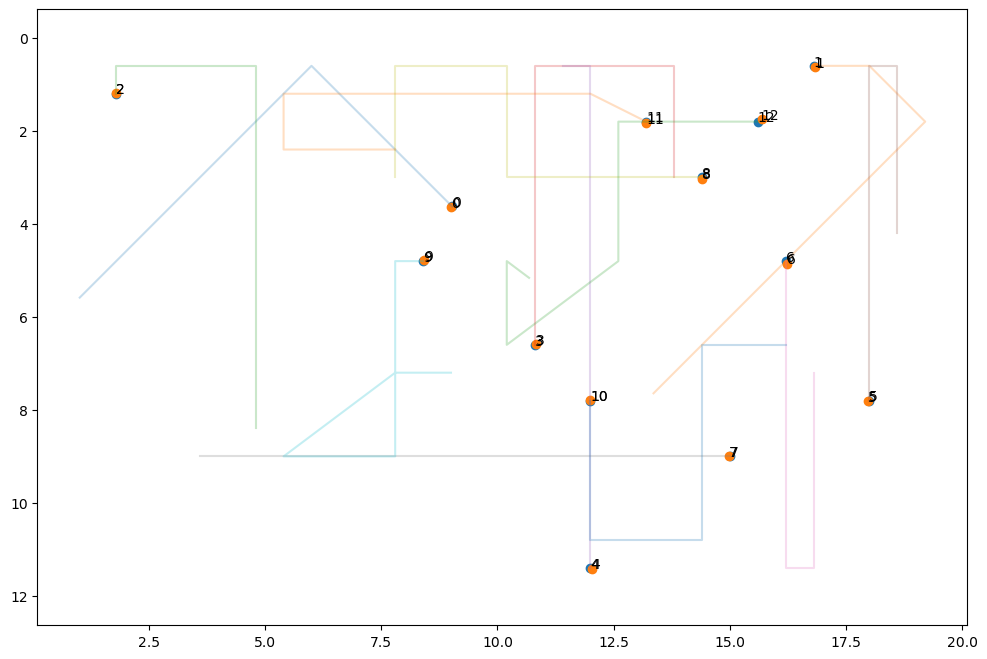

In [30]:
valid_loader = DataLoader(train_dataset, batch_size=32)
visualize(valid_loader, prep_valid_target_traj[(np.arange(prep_valid_target_traj.shape[0])) % 10 != 0, :, :])

(68, 2) (68, 2) (68,) (68, 20, 8)
Mean:  0.262	Median:  0.129


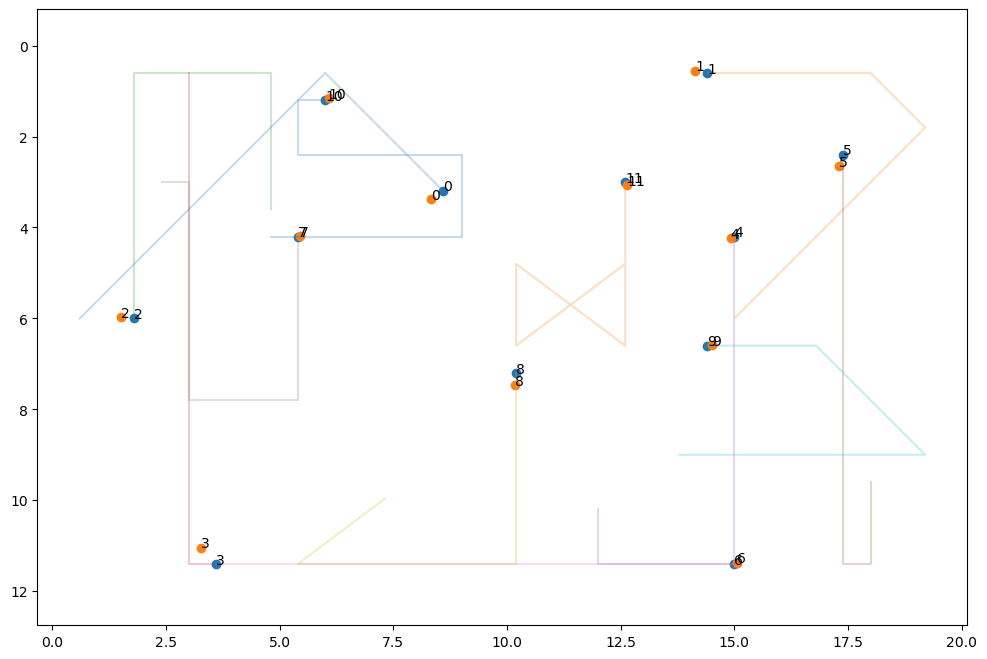

In [33]:
visualize(horizontal_loader, prep_valid_horizontal_traj[::10, :, :], 6)

(674, 2) (674, 2) (674,) (674, 20, 8)
Mean:  7.134	Median:  7.226


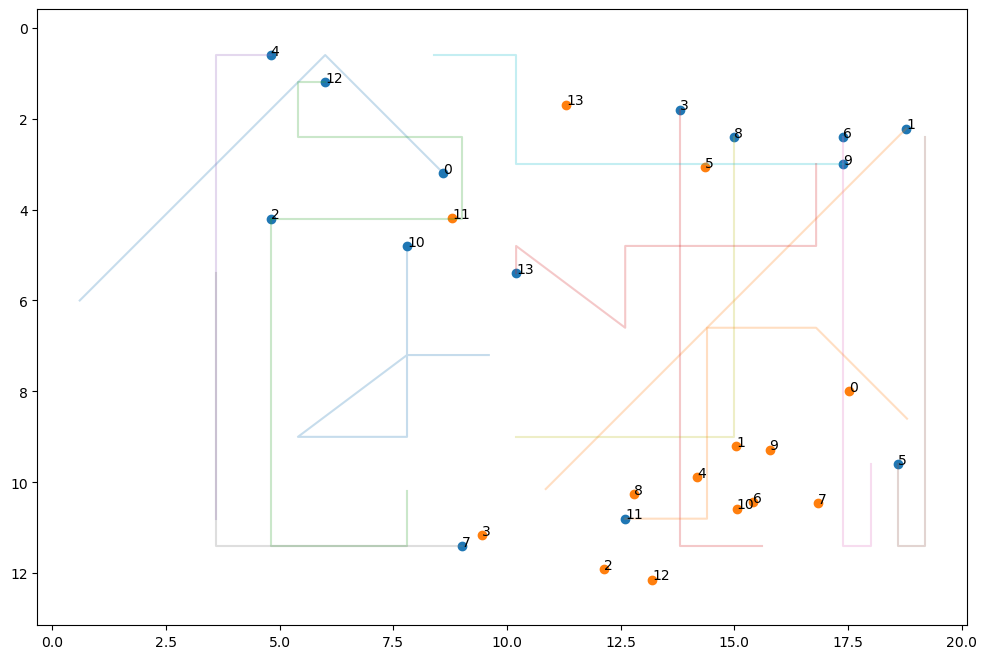

In [34]:
visualize(front_pocket_loader, prep_valid_front_pocket_traj)

(337, 2) (337, 2) (337,) (337, 20, 8)
Mean:  1.074	Median:  0.607


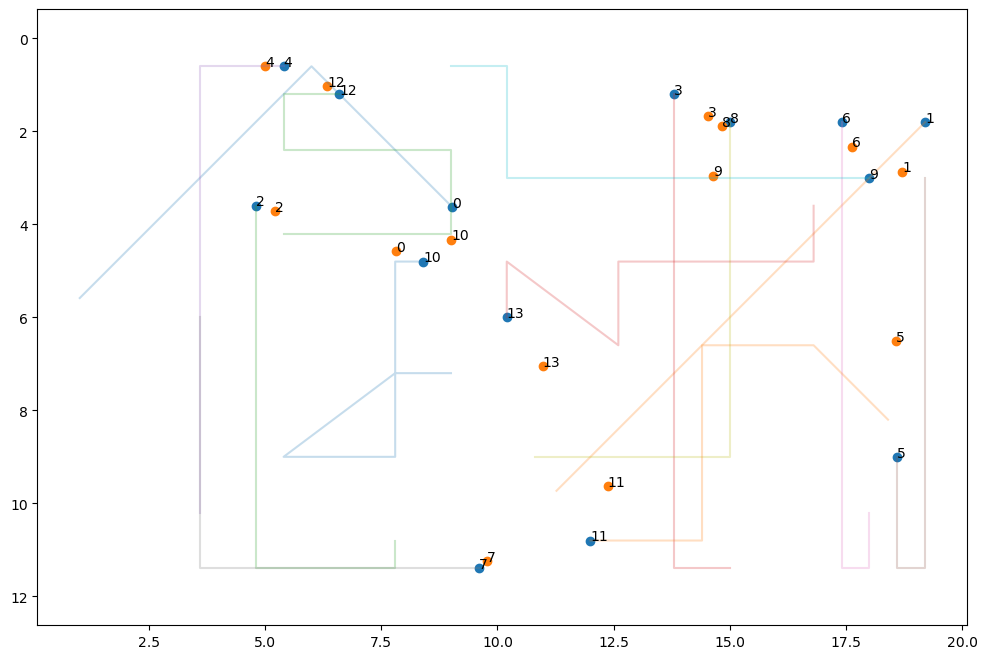

In [35]:
visualize(c_front_pocket_loader, cali_valid_front_pocket_traj, 25)

(674, 2) (674, 2) (674,) (674, 20, 8)
Mean:  5.482	Median:  5.234


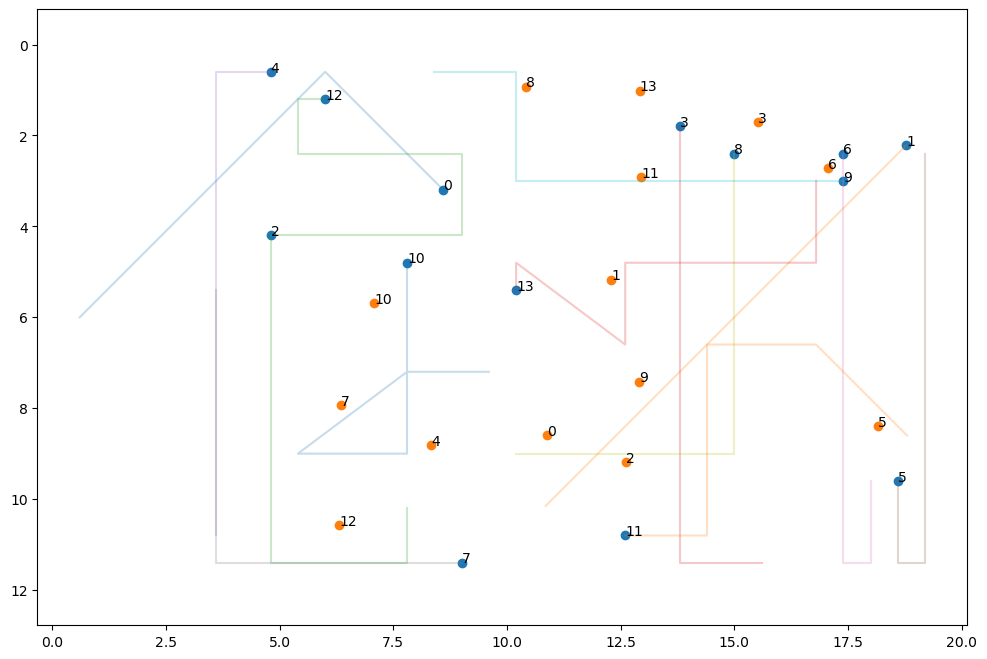

In [36]:
visualize(target_loader, prep_valid_target_traj)

(337, 2) (337, 2) (337,) (337, 20, 8)
Mean:  1.598	Median:  0.955


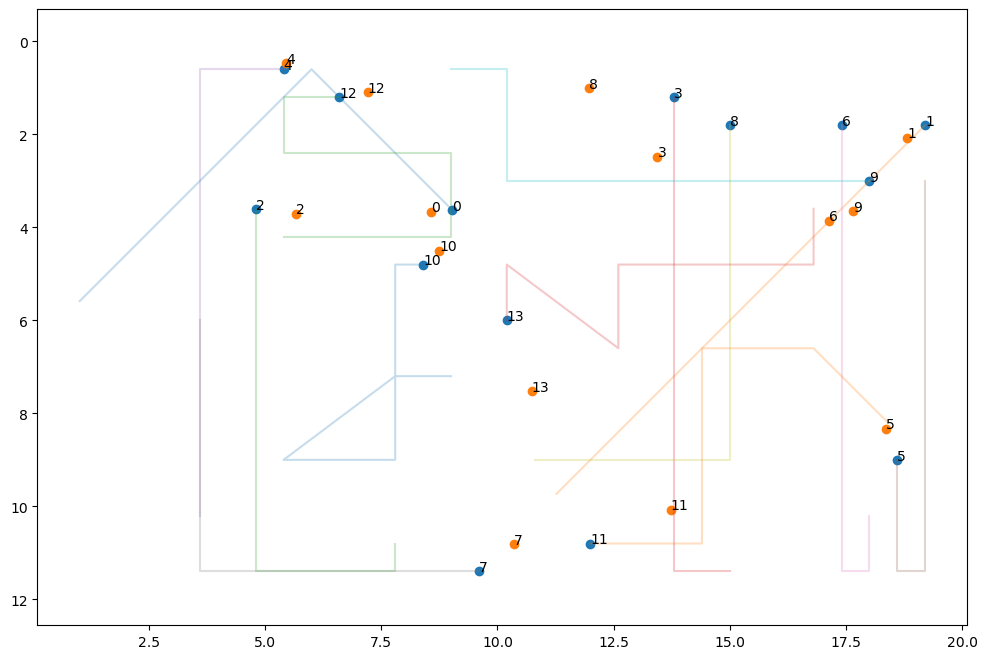

In [37]:
visualize(c_target_loader, cali_valid_target_traj, 25)

(674, 2) (674, 2) (674,) (674, 20, 8)
Mean:  6.688	Median:  6.569


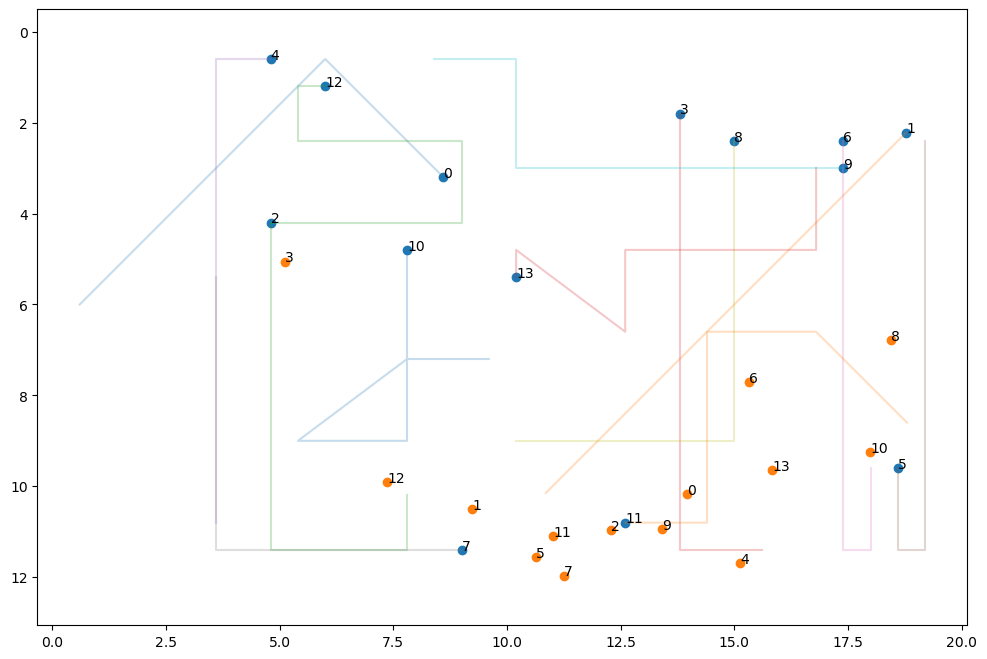

In [38]:
visualize(pocket_loader, prep_valid_pocket_traj)

(337, 2) (337, 2) (337,) (337, 20, 8)
Mean:  1.325	Median:  0.806


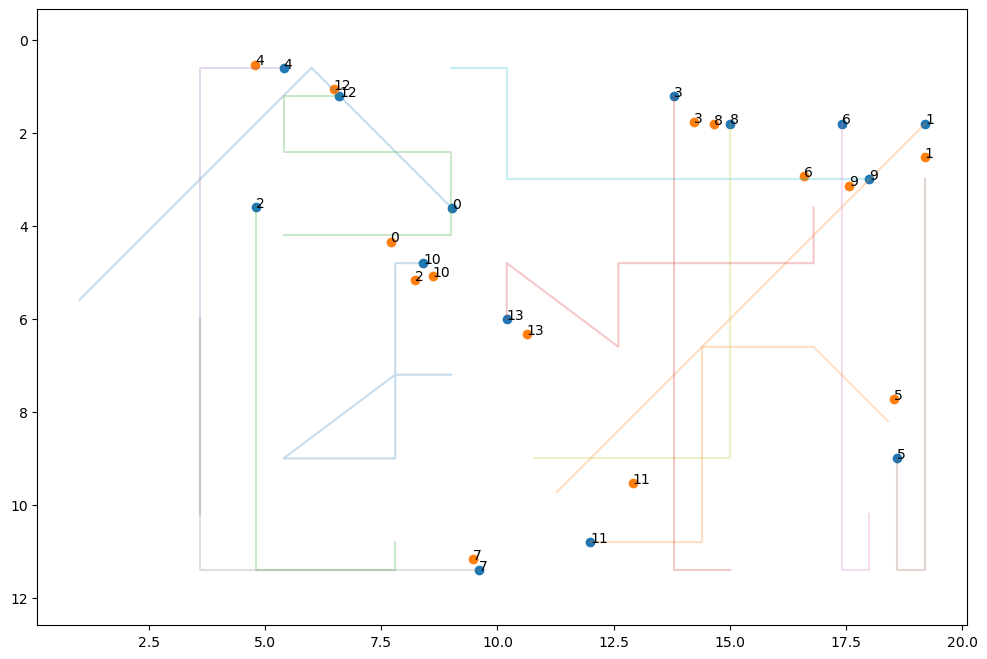

In [39]:
visualize(c_pocket_loader, cali_valid_pocket_traj, 25)

(674, 2) (674, 2) (674,) (674, 20, 8)
Mean:  6.840	Median:  7.155


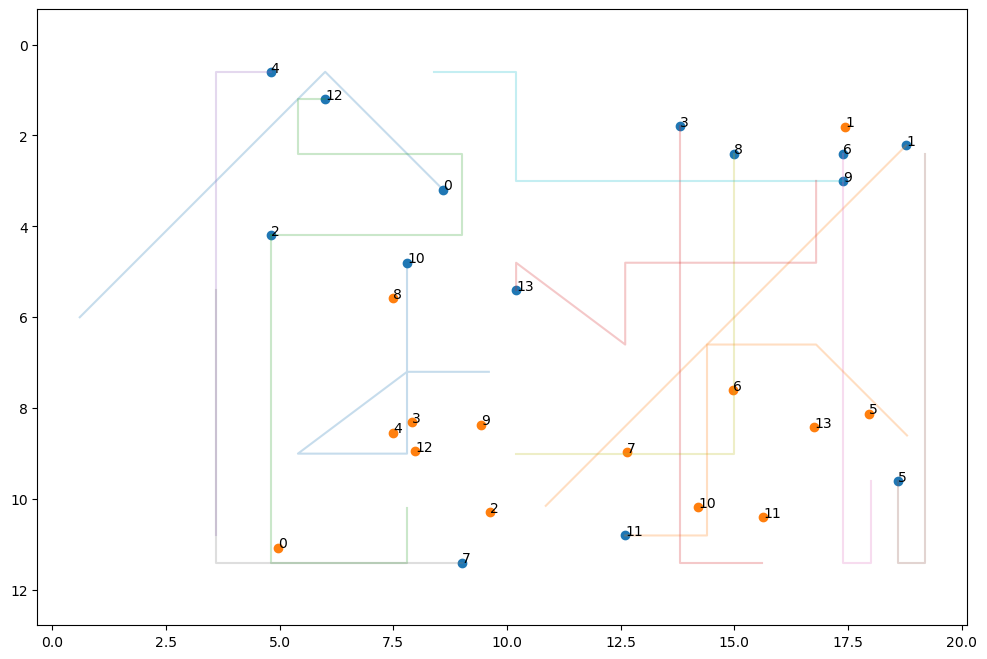

In [40]:
visualize(swing_loader, prep_valid_swing_traj)

(337, 2) (337, 2) (337,) (337, 20, 8)
Mean:  1.112	Median:  0.656


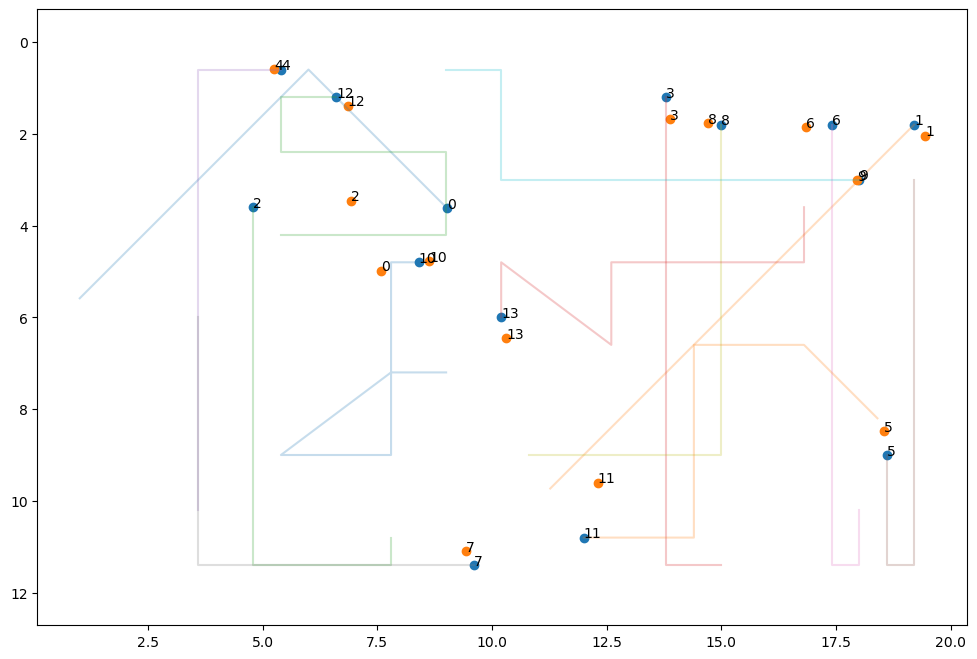

In [41]:
visualize(c_swing_loader, cali_valid_swing_traj, 25)